In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import sys
sys.path.append("../")
sys.path.append("../../submodules/gaussian-splatting")

import argparse
import copy

from matplotlib import pyplot as plt
import numpy as np
import skimage as ski
import torch

from helpers.polarization_helpers import *
from helpers.render_helpers import *
from helpers.hair_color_helpers import *

from scene import *
from scene.gaussian_model import *
from arguments import *
from gaussian_renderer import render

In [2]:
def load_vertices(objpath):
	vertices = []
	with open(objpath, 'r') as file:
		for line in file:
			if line.startswith("v "):
				parts = line.split()
				vertex = np.array([float(parts[1]), float(parts[2]), float(parts[3])])
				vertices.append(vertex)
	return np.array(vertices)

def load_head_mesh(objpath):
	vertices = []
	normals = []
	vertex_normals = []
	v_idx = 1
	vn_idx = 1
	with open(objpath, 'r') as file:
		head_found = False
		for line in file:
			if not head_found:
				if line.startswith("# object Marcus"):
					head_found = True
				else:
					if line.startswith("v "):
						v_idx += 1
					if line.startswith("vn "):
						vn_idx += 1
					continue

			if line.startswith("v "):
				parts = line.split()
				vertex = np.array([float(parts[1]), float(parts[2]) - 18.613872, float(parts[3]), 0.0, 0.0, 0.0])
				vertices.append(vertex)

			if line.startswith("vn "):
				parts = line.split()
				normal = np.array([float(parts[1]), float(parts[2]), float(parts[3])])
				normals.append(normal)

			if line.startswith("f "):
				parts = line.split()
				for i in range(1, len(parts)):
					v = int(parts[i].split("/")[0]) - v_idx
					vn = int(parts[i].split("/")[2]) - vn_idx
					vertices[v][3:] += normals[vn]

	vertices = np.array(vertices)
	normals = np.array(normals)

	vertex_normals = vertices[:, 3:]
	vertex_normals /= np.linalg.norm(vertex_normals, axis=1, keepdims=True) + 1e-8

	return vertices[:, :3], normals, vertex_normals

def closest_point_on_mesh(point, vertices, vertex_normals):
	distances = np.linalg.norm(vertices - point, axis=1)
	closest_index = np.argmin(distances)
	return vertices[closest_index], vertex_normals[closest_index]

def is_outside_mesh(point, vertices, vertex_normals):
	closest_point, normal = closest_point_on_mesh(point, vertices, vertex_normals)
	vector_to_point = point - closest_point
	vector_to_point /= np.linalg.norm(vector_to_point) + 1e-8
	return np.dot(vector_to_point, normal) > 0 and np.linalg.norm(point - closest_point) > 0.5

def points_outside_mesh(points, vertices, vertex_normals):
	num_points = points.shape[0]
	outside = np.full(num_points, False, dtype=bool)
	for i, point in enumerate(points):
		outside[i] = is_outside_mesh(point, vertices, vertex_normals)
	return outside

def load_gaussians(model_path, mesh_path, iteration=30_000):
	# load configuration
	parser = argparse.ArgumentParser()
	model = ModelParams(parser, sentinel=True)
	pipeline = PipelineParams(parser)

	cfgfilepath = os.path.join(model_path, "cfg_args")
	with open(cfgfilepath) as cfgfile:
		cfgfile_string = cfgfile.read()
	args_cfgfile = eval(cfgfile_string)
	merged_dict = vars(args_cfgfile).copy()
	args = argparse.Namespace(**merged_dict)

	dataset = model.extract(args)
	dataset.model_path = model_path
	pipe = pipeline.extract(args)

	pipe.convert_SHs_python = False
	pipe.compute_cov3D_python = False
	pipe.debug = False
	pipe.antialiasing = False

	# load gaussians and scene
	gaussians = GaussianModel(dataset.sh_degree)
	scene = Scene(dataset, gaussians, load_iteration=iteration, shuffle=False)
	pos = gaussians.get_xyz.clone().detach().cpu().numpy()

	# load head mesh
	vertices, normals, vertex_normals = load_head_mesh(mesh_path)
	
	# find points outside of mesh
	outside_mask = points_outside_mesh(pos, vertices, vertex_normals)

	# remove gaussians inside mesh
	th_mask = torch.tensor(outside_mask).to(gaussians.get_xyz.device)

	prev_size = gaussians.get_xyz.shape[0]

	gaussians._xyz = gaussians._xyz[th_mask]
	gaussians._features_dc = gaussians._features_dc[th_mask]
	gaussians._features_rest = gaussians._features_rest[th_mask]
	gaussians._scaling = gaussians._scaling[th_mask]
	gaussians._rotation = gaussians._rotation[th_mask]
	gaussians._opacity = gaussians._opacity[th_mask]

	print(f"Hair gaussians for {model_path}: {gaussians.get_xyz.shape[0]}/{prev_size}; {float(gaussians.get_xyz.shape[0])/float(prev_size)}")

	return gaussians, scene, dataset, pipe

def load_gaussians_fused(model_path, source1, source2, mesh_path, iteration=30_000):
	# load configuration
	parser = argparse.ArgumentParser()
	model = ModelParams(parser, sentinel=True)
	pipeline = PipelineParams(parser)

	cfgfilepath = os.path.join(model_path, "cfg_args")
	with open(cfgfilepath) as cfgfile:
		cfgfile_string = cfgfile.read()
	args_cfgfile = eval(cfgfile_string)
	merged_dict = vars(args_cfgfile).copy()
	args = argparse.Namespace(**merged_dict)

	dataset1 = model.extract(args)
	dataset1.model_path = model_path
	dataset2 = copy.deepcopy(dataset1)
	dataset1.source_path = source1
	dataset2.source_path = source2

	pipe = pipeline.extract(args)

	pipe.convert_SHs_python = False
	pipe.compute_cov3D_python = False
	pipe.debug = False
	pipe.antialiasing = False

	# load gaussians and scene
	gaussians = GaussianModel(dataset1.sh_degree, two_shs=True)
	scene = SeparatedScene(dataset1, dataset2, gaussians, load_iteration=iteration, shuffle=False)
	pos = gaussians.get_xyz.clone().detach().cpu().numpy()

	# load head mesh
	vertices, normals, vertex_normals = load_head_mesh(mesh_path)
	
	# find points outside of mesh
	outside_mask = points_outside_mesh(pos, vertices, vertex_normals)

	# remove gaussians inside mesh
	th_mask = torch.tensor(outside_mask).to(gaussians.get_xyz.device)

	prev_size = gaussians.get_xyz.shape[0]

	gaussians._xyz = gaussians._xyz[th_mask]
	gaussians._features_dc = gaussians._features_dc[th_mask]
	gaussians._features_rest = gaussians._features_rest[th_mask]
	gaussians._features_2_dc = gaussians._features_2_dc[th_mask]
	gaussians._features_2_rest = gaussians._features_2_rest[th_mask]
	gaussians._scaling = gaussians._scaling[th_mask]
	gaussians._rotation = gaussians._rotation[th_mask]
	gaussians._opacity = gaussians._opacity[th_mask]

	print(f"Hair gaussians for {model_path}: {gaussians.get_xyz.shape[0]}/{prev_size}; {float(gaussians.get_xyz.shape[0])/float(prev_size)}")

	return gaussians, scene, dataset1, dataset2, pipe

def render_from_viewpoint(scene, gaussians, pipe, cam_num):
	with torch.no_grad():
		bg_color = [0, 0, 0]
		bg = torch.tensor(bg_color, dtype=torch.float32).to(gaussians.get_xyz.device)

		view = scene.getTestCameras()[cam_num]
		rendering = render(view, gaussians, pipe, bg)["render"]

		fig, ax = plt.subplots()
		ax.imshow(rendering.detach().cpu().numpy().transpose((1,2,0)))
		ax.axis('off')
		return fig

In [3]:
output_path = os.path.abspath("../../output")
head_path = os.path.abspath("../../head_models")

gaussians_u, scene_u, dataset_u, pipe_u = load_gaussians(
	os.path.join(output_path, "tandem/unpolarized/model"),
	os.path.join(head_path, "Marcus_PBR_Sample_01/OBJ/Marcus_PBR_Sample_01.obj"),
	iteration=30_000
)

gaussians_d, scene_d, dataset_d, pipe_d = load_gaussians(
	os.path.join(output_path, "tandem/direct/model"),
	os.path.join(head_path, "Marcus_PBR_Sample_01/OBJ/Marcus_PBR_Sample_01.obj"),
	iteration=30_000
)

gaussians_g, scene_g, dataset_g, pipe_g = load_gaussians(
	os.path.join(output_path, "tandem/global/model"),
	os.path.join(head_path, "Marcus_PBR_Sample_01/OBJ/Marcus_PBR_Sample_01.obj"),
	iteration=30_000
)

Loading trained model at iteration 30000
Reading camera 76/76
Loading Training Cameras
Loading Test Cameras
Hair gaussians for /home/student_kaempchen/bachelorarbeit/output/tandem/unpolarized/model: 26336/62206; 0.42336752081792756
Loading trained model at iteration 30000
Reading camera 76/76
Loading Training Cameras
Loading Test Cameras
Hair gaussians for /home/student_kaempchen/bachelorarbeit/output/tandem/direct/model: 105346/134523; 0.7831077213561993
Loading trained model at iteration 30000
Reading camera 76/76
Loading Training Cameras
Loading Test Cameras
Hair gaussians for /home/student_kaempchen/bachelorarbeit/output/tandem/global/model: 90367/152735; 0.5916587553605919


In [4]:
gaussians_f, scene_f, dataset1_f, dataset2_f, pipe_f = load_gaussians_fused(
	os.path.join(output_path, "fused", "composite", "model"),
	os.path.join(output_path, "fused", "global", "colmap"),
	os.path.join(output_path, "fused", "direct", "colmap"),
	os.path.join(head_path, "Marcus_PBR_Sample_01", "OBJ", "Marcus_PBR_Sample_01.obj"),
	iteration=30_000
)

Loading trained model at iteration 30000
Reading camera 76/76
Reading camera 76/76


Hair gaussians for /home/student_kaempchen/bachelorarbeit/output/fused/composite/model: 84721/133294; 0.6355950005251549


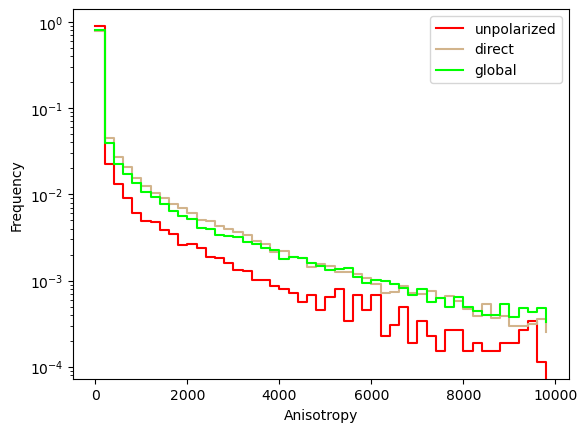

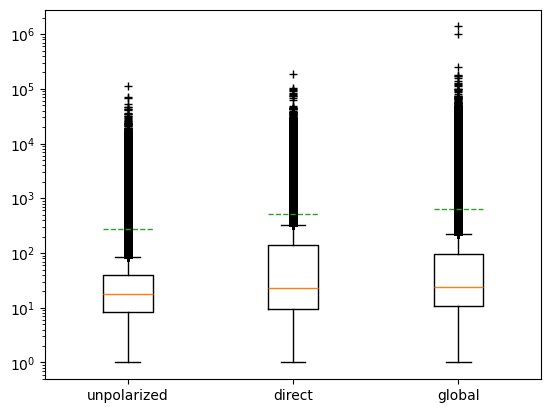

0.9955574119076549
0.9939627513147155
0.9896643686301416


In [27]:
def calculate_anisotropy(gaussians):
	return (gaussians.get_scaling.amax(dim=1) / (gaussians.get_scaling.amin(dim=1) + 1e-8)).detach().cpu().numpy()

def calculate_anisotropy_2(scalings):
	return np.amax(scalings, axis=1) / np.partition(scalings, 1, axis=1)[:, 1]

alpha = 1
# colors = [(1.0,0.0,0.0,alpha),(0.0,1.0,0.0,alpha),(0.0,0.0,1.0,alpha)]
colors = ["red", "tan", "lime"]
labels = ["unpolarized", "direct", "global"]
bins = 50
# anisotropy = [calculate_anisotropy(g) for g in [gaussians_u, gaussians_d, gaussians_g]]
anisotropy = [calculate_anisotropy_2(g.get_scaling.detach().cpu().numpy()) for g in [gaussians_u, gaussians_d, gaussians_g]]
n, bins, _ = plt.hist(anisotropy, bins=bins, histtype="step", range=(0, 1e4), density=False, log=False, color=colors, label=labels)
plt.clf()

n[0] /= gaussians_u.get_xyz.shape[0]
n[1] /= gaussians_d.get_xyz.shape[0]
n[2] /= gaussians_g.get_xyz.shape[0]

plt.step(bins[:-1], n[0], where='post', color=colors[0], label=labels[0])
plt.step(bins[:-1], n[1], where='post', color=colors[1], label=labels[1])
plt.step(bins[:-1], n[2], where='post', color=colors[2], label=labels[2])
plt.yscale("log")
plt.xlabel("Anisotropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.boxplot(anisotropy, tick_labels=labels, showmeans=True, meanline=True, sym="k+")
plt.yscale("log")
plt.show()

print(np.sum(n[0]))
print(np.sum(n[1]))
print(np.sum(n[2]))

In [5]:
def band_indices(sh_degree=3):
	indices = []
	start = 0

	for l in range(sh_degree + 1):
		size = 2 * l + 1
		indices.append((l, start, start + size))
		start += size

	return indices

def band_energies(coeffs, sh_degree=3):
	N = coeffs.shape[0]
	energies = np.zeros((N, sh_degree + 1), dtype=np.float32)

	for l, s, e in band_indices(sh_degree):
		energies[:, l] = np.linalg.norm(coeffs[:, s:e], axis=1)

	return energies

def luminance(coeffs):
	return 0.2126 * coeffs[..., 0] + 0.7152 * coeffs[..., 1] + 0.0722 * coeffs[..., 2]

def energy(coeffs, sh_degree=3):
	coeffs_lum = luminance(coeffs)
	energies = band_energies(coeffs_lum, sh_degree=sh_degree)
	total_energies = np.sum(energies, axis=1)
	weighted_energies = np.zeros_like(total_energies)

	for l in range(sh_degree + 1):
		weighted_energies += energies[:, l] * l

	return weighted_energies / (total_energies + 1e-8)

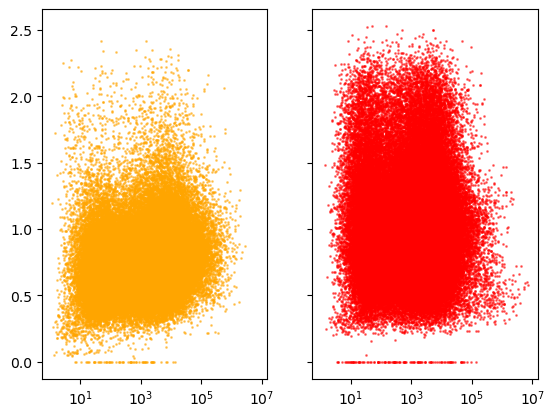

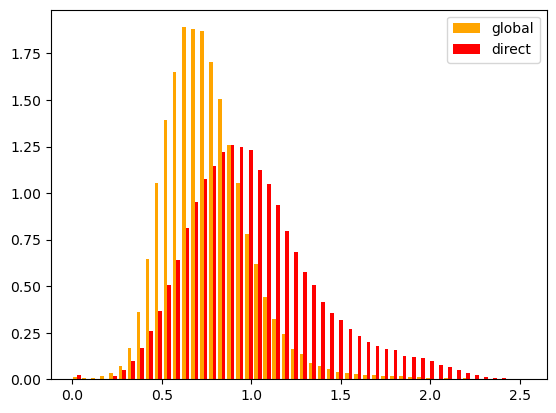

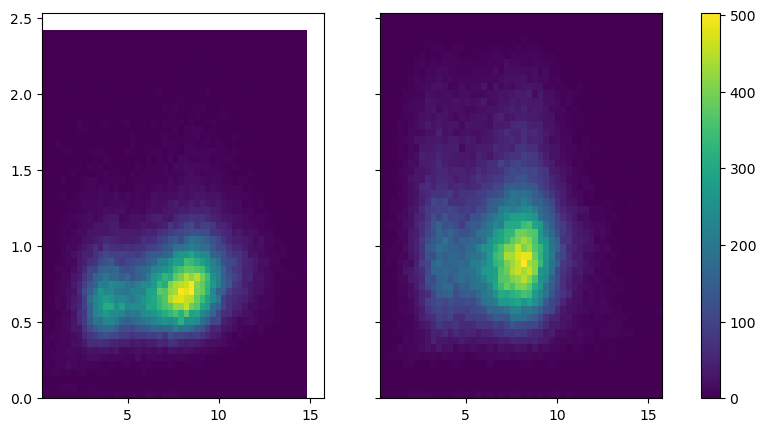

In [22]:
features_d = gaussians_d.get_features.detach().cpu().numpy()
energies_d = energy(features_d, sh_degree=3)
scaling_d = gaussians_d.get_scaling.detach().cpu().numpy()
# anisotropy_d = calculate_anisotropy_2(scaling_d)
anisotropy_d = calculate_anisotropy(gaussians_d)
features_g = gaussians_g.get_features.detach().cpu().numpy()
energies_g = energy(features_g, sh_degree=3)
scaling_g = gaussians_g.get_scaling.detach().cpu().numpy()
# anisotropy_g = calculate_anisotropy_2(scaling_g)
anisotropy_g = calculate_anisotropy(gaussians_g)
size_g = np.linalg.norm(gaussians_g.get_scaling.detach().cpu().numpy(), axis=1)
size_d = np.linalg.norm(gaussians_d.get_scaling.detach().cpu().numpy(), axis=1)
opacity_g = gaussians_g.get_opacity.detach().cpu().numpy()
opacity_d = gaussians_d.get_opacity.detach().cpu().numpy()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].scatter(anisotropy_g, energies_g, s=1, alpha=0.5, label="global", c="orange")
ax[0].set_xscale("log")
ax[1].scatter(anisotropy_d, energies_d, s=1, alpha=0.5, label="direct", c="red")
plt.show()

plt.hist([energies_g, energies_d], bins=50, density=True, color=["orange", "red"], label=["global", "direct"])
plt.legend()
plt.show()

bins = 50
norm = "linear"
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
_, _, _, image = ax[0].hist2d(np.log(anisotropy_g), energies_g, bins=bins, norm=norm)
ax[1].hist2d(np.log(anisotropy_d), energies_d, bins=bins, norm=norm)
fig.colorbar(image, ax=ax)
# ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
# ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
plt.show()

# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
# ax[0].scatter(size_g, energies_g, s=1, alpha=0.5, label="global", c="orange")
# ax[1].scatter(size_d, energies_d, s=1, alpha=0.5, label="direct", c="red")
# plt.show()

# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
# ax[0].scatter(opacity_g, energies_g, s=1, alpha=0.5, label="global", c="orange")
# ax[1].scatter(opacity_d, energies_d, s=1, alpha=0.5, label="direct", c="red")
# plt.show()

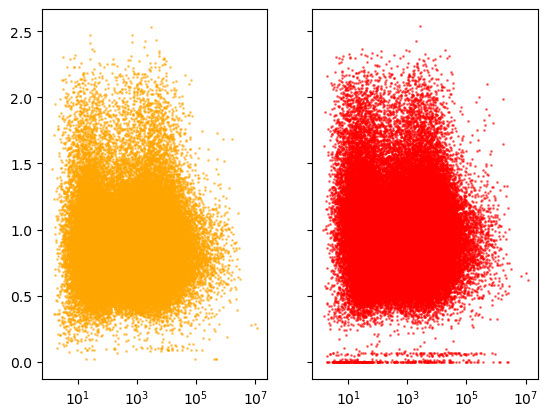

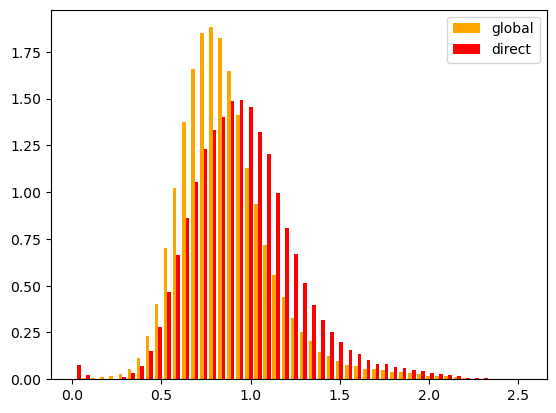

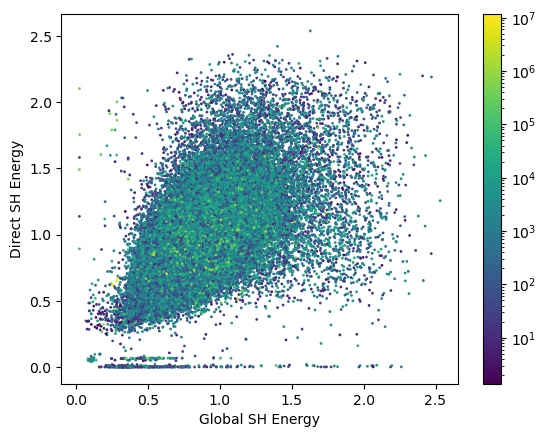

In [35]:
features_g = gaussians_f.get_features.detach().cpu().numpy()
features_d = gaussians_f.get_features_2.detach().cpu().numpy()
energies_g = energy(features_g, sh_degree=3)
energies_d = energy(features_d, sh_degree=3)
anisotropy = calculate_anisotropy(gaussians_f)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].scatter(anisotropy, energies_g, s=1, alpha=0.5, label="global", c="orange")
ax[0].set_xscale("log")
ax[1].scatter(anisotropy, energies_d, s=1, alpha=0.5, label="direct", c="red")
plt.show()

plt.hist([energies_g, energies_d], bins=50, density=True, color=["orange", "red"], label=["global", "direct"])
plt.legend()
plt.show()

plt.scatter(energies_g, energies_d, s=1, c=anisotropy, norm="log")
plt.xlabel("Global SH Energy")
plt.ylabel("Direct SH Energy")
plt.colorbar()
plt.show()